### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import copy
from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import datetime

import time

import warnings
warnings.filterwarnings("ignore")

### Visualisation of a synthetic signal

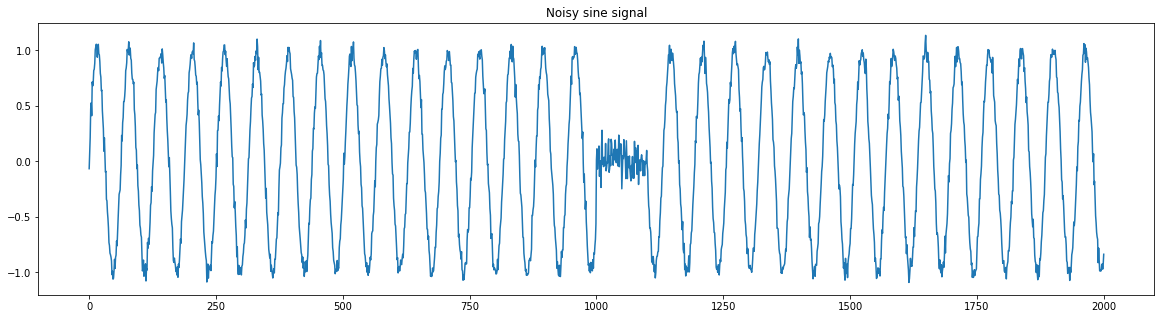

In [ ]:
data = loadmat("/content/NoisySine.mat") 
T = data['T'].reshape(-1)

plt.figure(figsize=(20,5))
plt.title("Noisy sine signal")
plt.plot(T)
plt.show()


### Implementation of the code

In [ ]:
def z_norm(T):
  """  
  Coding the z norm that has been used to compute the discord norms.
  Input
  ########################################################
    T: darray

  Output
  ########################################################
    Z-Norm of the input array
  """
  std = np.std(T, axis=0, keepdims=True)
  std[std == 0] = 1
  return (T - np.mean(T, axis=0, keepdims=True)) / std

In [ ]:
#First phase of Merlin algorithm : DRAG

def candidate_selection_algorithm(T, m, r) :
    """
    The method discovers a collection of discords with a distance from their NN greater than r for a time sequence T.
    
    Input
    #######################################################################################################################
    T: darray
        The time series on which we want to find the outliers
    
    m: int
        the length of the subsequence to take into account while looking for discords
    
    r: float
        the maxiumum distance between a non-discord subsequence and its nearest neighbor subsequence that can be permitted.
    
    
    Output
    #######################################################################################################################
    C: set
        a set of initial discords
    
    """
    #empty set to store the discords
    C = set()
    
    #run through all subsequences 
    for i in range(0,len(T)-m):
        candidate = True
        T_i = T[i:(i+m)]                                 # taking the first sequence
        T_i = z_norm(T_i)                                 # Computing the z_norm for the sequence.
            
        for j in C:
            if abs(i-j)>=m:                               #non-trival match  test 
                
                T_j = T[j:(j+m)]        
                
                T_j = z_norm(T_j)
                
                distance = np.linalg.norm(T_i-T_j)
                
                if distance < r :                        # If we find just one distance that is less than r
                    candidate = False                    # it means that the selected sequence is not a discord
                    break                                
        
        if candidate:                                    # if it is a candidate, we add 'i' to the set of candidates
            C.add(i)
        else:                                            # if it is not, we remove j from the candidate set (C). 
            C.remove(j)
            
    return C                                             # return the set of candidates, if it is empty, we will treat it as a failure

In [ ]:
#Second part of DARG algorithm

def discords_refinement_algorithm(T,m,r,C):
    """
       The method refines a collection of discords for the time series T by deleting false positives.
    
    Input
    #######################################################################################################################
    T: darray
        The time series on which we want to find the outliers
    
    m: int
        the length of the subsequence to take into account while looking for discords
    
    r: float
        the maxiumum distance between a non-discord subsequence and its nearest neighbor subsequence that can be permitted.
    
    C: set
        the set of indices of first discovered discored
    
    
    Output
    #######################################################################################################################
    discords: dataframe
        a dataframe where each row corresponds to a discovered discord 
        The columns are: ['Discord index', 'distance']
        
    """
    C= list(C)
    
    results=np.zeros(shape=(len(C),2)) # a numpy array to store the discrods 
    results[:,0] = C
    results[:,1] = 1e9            
    
    non_discords = []
    
    if len(C)==0:
        print('The set C is empty. No discord discovered!')
        return 0
    
    for i in range(0, len(T)-m):
        
        #Obvious case
        if len(C)==0:
            print('The set C is empty. No discord discovered!')
            break
            
        # Other cases    
        T_i = z_norm(T[i:(i+m)])                    
        
        for iter_j , j in enumerate(C):
            if iter_j not in non_discords:                  # in order to avoid redundacy
                if abs(i-j)>=m:                             # Check for non trivial sets.
                    
                    T_j = z_norm(T[j:(j+m)])

                    distance = np.linalg.norm(T_i-T_j)
                    
                    if distance >= r:                       # if we find a discord that is higher than r
                        
                        if distance<results[iter_j,1]:            # if the current distance is smaller than the distance that already exist      
                            results[iter_j,1] = distance          # update the distance of this NN.
                    else :
                        non_discords.append(iter_j)
            
    results_cleaned = np.delete(results, non_discords, axis=0)         #update the list of candidates
    
    discords_dataframe = pd.DataFrame(data = results_cleaned, columns = ['Discord index','Discord distance'])
        
    return discords_dataframe

### Testing on a toy dataset 

With good values of m and r, we have identified the presented outlier.

In [ ]:
T= T[:]
m = 100 
r = 10.27
C = candidate_selection_algorithm(T, m, r)
print(' The initial set of discrods is: \n', C)

 The initial set of discrods is: 
 {1786, 1787, 1788, 1789, 1790, 1791, 1806, 1807, 1808, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1819, 1832, 1836, 1838, 1850, 1869, 1870, 1871, 1873, 1875, 1878, 1879, 1880, 1881, 1895, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019}


In [ ]:
#Printing the discords and its corresponding index in a descending order
discords = discords_refinement_algorithm(T, m, r, C)
discords_sorted = discords.sort_values(by ='Discord distance', ascending=False, ignore_index=True)
discords_sorted

,Discord index,Discord distance
0,1005.0,13.685567
1,1004.0,13.641400
2,1006.0,13.402647
3,1003.0,13.246754
4,1007.0,12.983597
5,1002.0,12.853911
6,1001.0,12.798037
7,1000.0,12.733145
8,999.0,12.655278
9,1008.0,12.653477


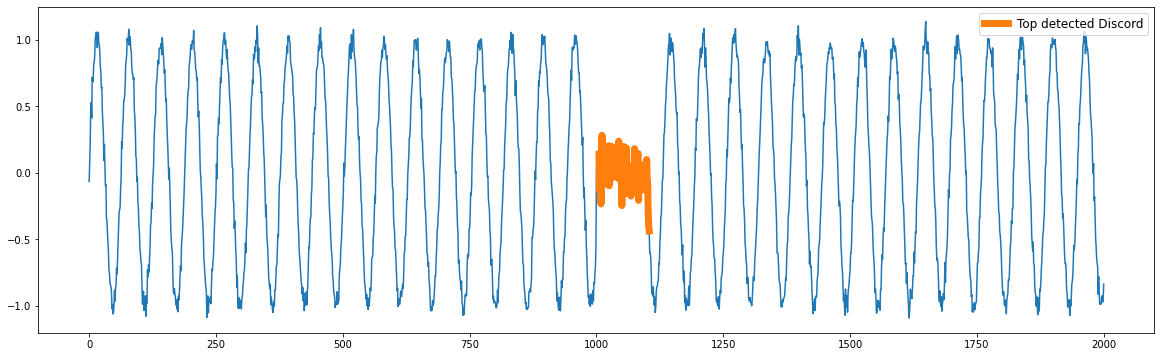

In [ ]:
# Visualization of the top detected discord

Top_Discord = discords_sorted.iloc[0,:]
Top_Discord_index = int(Top_Discord[0])
plt.figure(figsize=(20,6))
plt.plot(T)
plt.plot(np.arange(Top_Discord_index,Top_Discord_index+m),T[Top_Discord_index:Top_Discord_index+m], lw=7, label='Top detected Discord')
plt.legend(fontsize=12)
plt.show()

### DRAG algorithm

Combining the two implemented algorithm to form the final DRAG algorithm that outputs only the top 1 discrod.

In [ ]:
def DRAG(T,m,r):
    """
    This function combines the first two algorithms of the merlin.
    The method discovers a collection of discords with a distance from their NN greater than r for a time sequence T.

    Input
    #######################################################################################################################
    T: ndarray
    the time series for which we try to find the discords

    m: int
    the length of the subsequence to consider in discovering the discords

    r: float
    the maximum distance allowed for non-discord subsquence to its NN subsequence 
    (threshold for discords' distance)


    Output
    #######################################################################################################################
    index: index of top discord
    distance: dist between top discor and its NN  
    """

    #initializing output
    index = -1
    distance = -1

    C = candidate_selection_algorithm(T, m, r) 

    if len(C)>0:
        discords = discords_refinement_algorithm(T, m, r, C)

        if len(discords['Discord distance'])>0:
            top_discord = discords['Discord distance'].argmax()
            index = int(discords.iloc[top_discord, 0])
            distance = discords.iloc[top_discord, 1] 

    return index, distance

In [ ]:
# Top 1 discord.
TopDiscord_index,TopDiscord_distance = DRAG(T,m,r) 
print("TopDiscord_index: ", TopDiscord_index , ",TopDiscord_distance: ", TopDiscord_distance)

TopDiscord_index:  -1 ,TopDiscord_distance:  -1


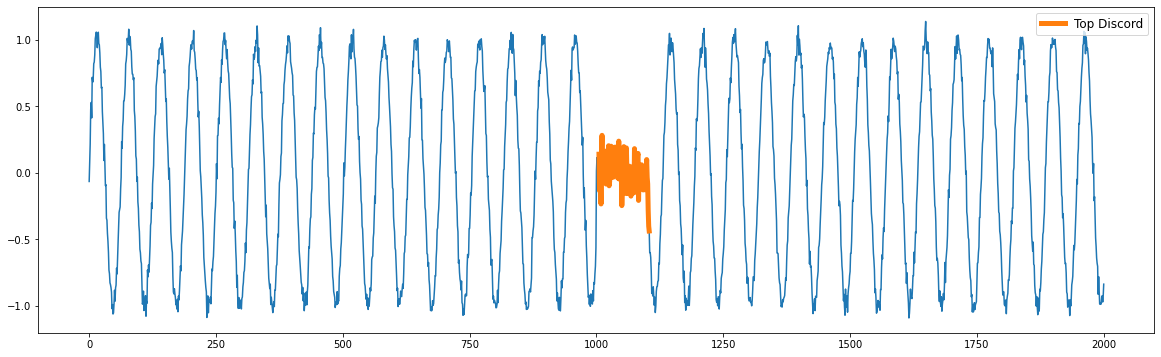

In [ ]:
#Testing if DRAG algorithm works well.

Top_Discord = discords_sorted.iloc[0,:]
Top_Discord_index = int(TopDiscord_index)
plt.figure(figsize=(20,6))
plt.plot(T)
plt.plot(np.arange(TopDiscord_index,TopDiscord_index+m),T[TopDiscord_index:TopDiscord_index+m], lw=7, label='Top detected Discord')
plt.legend(fontsize=12)
plt.show()

### Execution time for DRAG

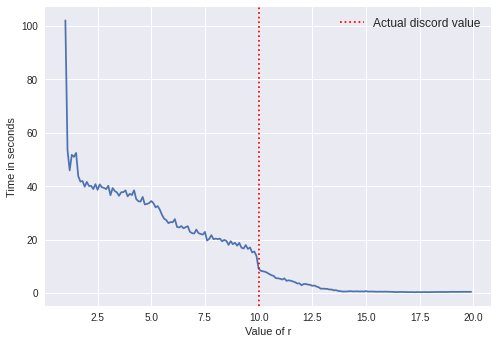

In [ ]:
#Used for the noisy dataset

time_exec_drag = []

for r in np.arange(1.0, 20.0, 0.1):
    start_time = time.time()
    TopDiscord_index, TopDiscord_distance = DRAG(T,m,r)
    time_exec_drag.append(time.time() - start_time)


plt.style.use('seaborn')
plt.plot(np.arange(1.0, 20.0, 0.1), time_exec_drag)
plt.xlabel("Value of r")
plt.ylabel("Time in seconds")
plt.axvline(x=10, color='r', ls=':', label='Actual discord value')
plt.legend(fontsize=12)
plt.show()

### Merlin algorithm

In [ ]:
def MERLIN(T, min_length, max_length):
    """
    For a time series T, the algorithm finds discords with length between MinL and MaxL. 
    Input
    #######################################################################################################################
    T: ndarray
        the time series for which we try to find the discord

    min_length: int
        subsequence length lower bound
    
    max_length: int
        subsequence length upper bound
    
    
    Output
    #######################################################################################################################
    Discords : ndarray
        A multi dimensional array of size (max_length-min_length+1) x 3:
          first position contains the starting index of the discord subsequence
          second position contains the length of the discord
          fourth position is the distance of the discord to its NN
    
    """
    Discords = np.empty(shape = (0, 3), dtype='object') 
    
    # Calculate the first discord of length min_length
    print('Calculation of  the first discord')
    m = min_length                                                                  # First discrod size
    r = 2 * (m ** 0.5)                                                              # First distance as stated in the paper
    distance = -1
    # running until we have our first success case.
    while distance < 0:
        index, distance = DRAG(T, m, r)
        r = r / 2                                                                   # devide the r by 2 in case of fail
    
    discord = [index, m, distance]
    Discords = np.vstack((Discords, discord))
    print('The first discord is :  \n', discord)
    
    print('Calculation of the the next four discords')
    old_distance = distance # we need the distance of the previous discord to modify r
  
    for m in range(min_length+1,min_length+5): 
        r = 0.99 * old_distance 
        
        distance = -1
        # running until we have our first success case.
        while distance < 0:
            index, distance = DRAG(T, m, r)
            r = 0.99 * r
            
        discord = [index, m,distance]
        Discords = np.vstack((Discords, discord))
        old_distance = distance
        print('The new added Discord  ', discord)
    
    
    # Calculate the remaining discords
    print('Calculation of the the remaining discords')

    for m in range(min_length+5, max_length+1): 

        mu_distance = np.mean(Discords[-5:, 2]) # calculation of the mean of distance for the last 5 discovered discords 
        std_distance = np.std(Discords[-5:, 2]) # calculation of the std of distance for the last 5 discovered discords
        
        r = mu_distance - 2 * std_distance      # updating r like stated in the article
        
        distance = -1
        # running until we have our first success case.
        while distance < 0:   
            index,distance = DRAG(T, m, r)
            r = r - std_distance
        
        discord = [index, m, distance]
        Discords = np.vstack((Discords, discord))
        print('The new added Discord  ', discord)
    
    return Discords

Now we are going to test the MERLIN algorithm on real life datasets. We will start by :

### nyc  taxi dataset

In [ ]:
#read data
df_taxi = pd.read_csv("/content/nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])
data =  df_taxi.loc['2014-07-01 00:00:00' : '2015-01-31 23:30:00']
data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


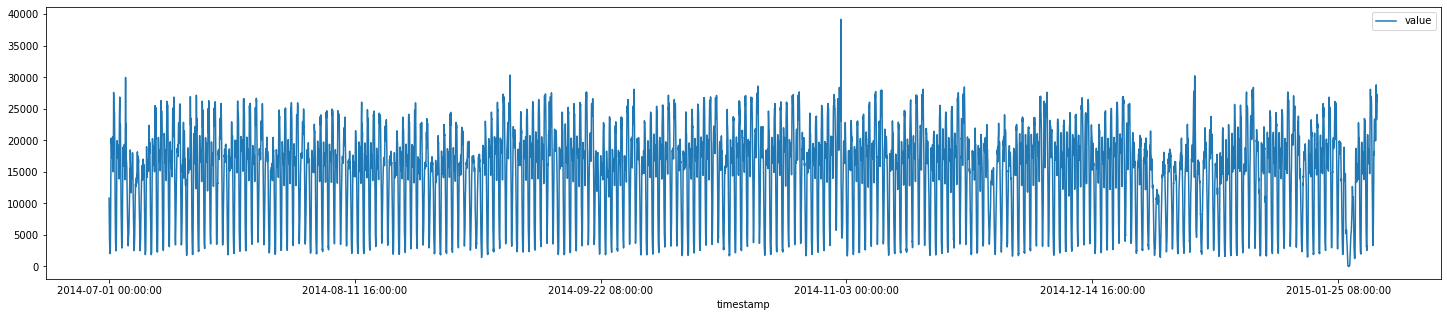

In [ ]:
# Visualization of the data
data.plot(figsize=(25,5))

First let's see if the **DRAG** algorithm works fine 

In [ ]:
T = np.reshape(data.to_numpy(),newshape=(-1,))
m = 24 * 2 # length of 1 day discrod.
r = 4.2
TopDiscord_index,TopDiscord_distance = DRAG(T,m,r) 

print("Top Discord index: ", TopDiscord_index)
print("Top Discord distance: ", TopDiscord_distance)

Top Discord index:  10098
Top Discord distance:  4.5504395019660295


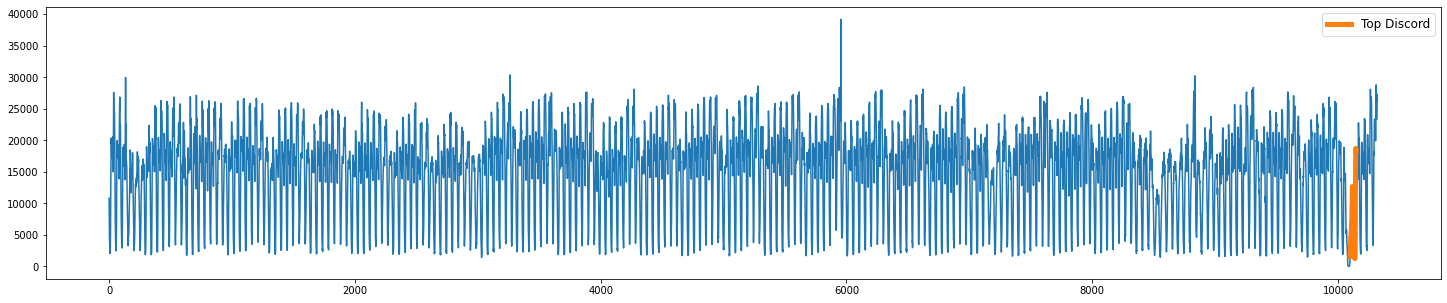

In [ ]:
# Visualization of the top discord ( we will explore later its corresponding date.)
plt.figure(figsize=(25,5))
plt.plot(T)
plt.plot(np.arange(TopDiscord_index,TopDiscord_index+m),T[TopDiscord_index:TopDiscord_index+m], lw=5, label='Top Discord')
plt.legend(fontsize=12)
plt.show()

In [ ]:
print(" The corresponding date to this discord is ", data.index[TopDiscord_index] )

 The corresponding date to this discord is  2015-01-27 09:00:00


This date corresponds to a big storm that stroke USA.

#### Running MERLIN on all the nyc taxi dataset.


In [ ]:
#Merling on all the datatakes too much time to run !
Discords = MERLIN(T, 48, 53)

Calculation of  the first discord
The first discord is :  
 [10098, 48, 4.5504395019660295]
Calculation of the the next four discords
The new added Discord   [10098, 49, 4.59363118827689]
The new added Discord   [10099, 50, 4.600351979368822]
The new added Discord   [10099, 51, 4.609233387645601]
The new added Discord   [10099, 52, 4.633921636100447]
Calculation of the the remaining discords
The new added Discord   [10099, 53, 4.647433449259413]


The whole dataset contains too much points to run, for that reason, we are going to do some downsampling and consider the frame of one hour instead of every 30 mins so that we can detect discrods of longer lenghts.

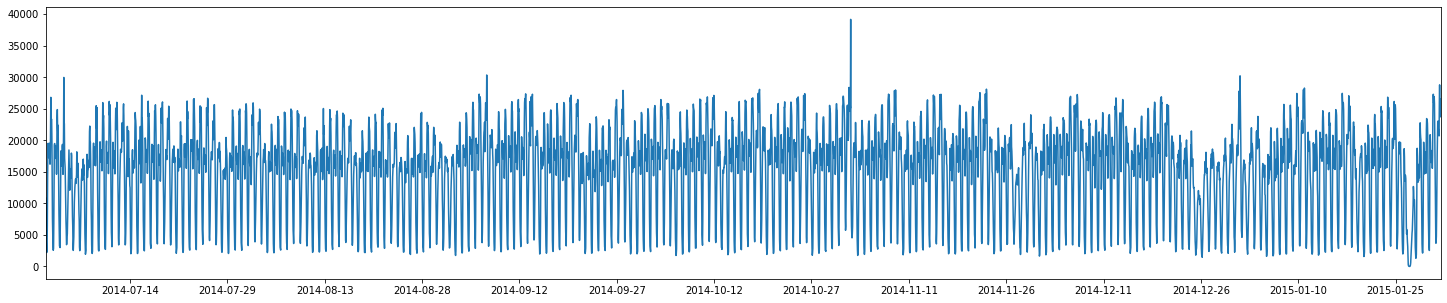

Calculation of  the first discord
The first discord is :  
 [3947, 5, 0.9160218372224147]
Calculation of the the next four discords
The new added Discord   [4812, 6, 1.5547411113472085]
The new added Discord   [1477, 7, 1.8796783094857787]
The new added Discord   [1477, 8, 2.545502956255382]
The new added Discord   [4500, 9, 2.445699271518163]
Calculation of the the remaining discords
The new added Discord   [4261, 10, 2.3522091659016326]
The new added Discord   [87, 11, 2.4970134313765966]
The new added Discord   [2967, 12, 2.746225055671875]
The new added Discord   [86, 13, 2.9855573045055364]
The new added Discord   [2965, 14, 3.353549996445389]
The new added Discord   [2964, 15, 3.590234294368303]
The new added Discord   [2963, 16, 3.7477780614645524]
The new added Discord   [2962, 17, 3.6748634927057156]
The new added Discord   [2961, 18, 3.3253013097263184]
The new added Discord   [2961, 19, 3.1618392855708963]
The new added Discord   [2960, 20, 2.8985780733789492]
The new added 

In [ ]:
df_taxi = pd.read_csv("/content/nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])
data =  df_taxi.loc['2014-07-01 00:00:00' : '2015-01-31 23:30:00']
T = np.reshape(data.to_numpy(),newshape=(-1,))

#let's consider only the data at each hour (to reduce computational time)

T = [val for i,val in enumerate(T) if i % 2 == 0]
T = np.asarray(T)

plt.figure(figsize=(25,5))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

start = datetime.datetime.strptime('2014-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end = datetime.datetime.strptime('2015-01-31 23:30:00', '%Y-%m-%d %H:%M:%S')

days = mdates.drange(start,end,dt.timedelta(hours=1))
plt.xlim([days[0], days[-1]])

plt.plot(days,T)
plt.show()

#detecting discords at the level of 5 hours to 2 days 
Discords = MERLIN(T, 5, 48)

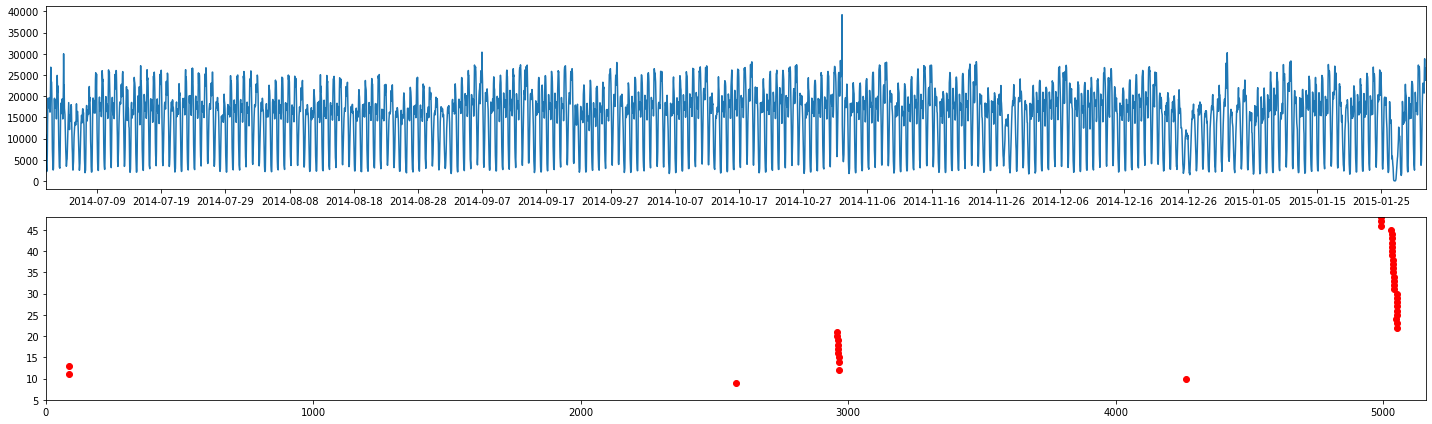

In [ ]:
#5-48 discrods
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20,6))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=10))

start = datetime.datetime.strptime('2014-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')

end = datetime.datetime.strptime('2015-01-31 23:30:00', '%Y-%m-%d %H:%M:%S')

days = mdates.drange(start,end,dt.timedelta(hours=1))

ax[0].set_xlim(left=days[0], right=days[-1]) 
ax[0].plot(days,T)

ax[1].set_xlim(left=0, right=len(T)-1) 
ax[1].set_ylim(bottom=5, top=48)

for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

We tested the  MERLIN algorithm on an interval of subsequences between the frames of 5 hours and 48 hours (2 days).  we can see that we have detected many outliers. Checking with the main events in New York this period we report them in the following order. The first discord corresponds to the $4^{th}$ of July (the independence day), then we have the St Luke’s day on October $18^{th}$ , then we have detected many discords at different lengths which correspond to the NYC marathon on 02/11/2014 then probably and outlier ($L=5$) then we detected the Christmas Eve ( with only one discord length on  24/12/2014 and finally we detected many discords with high subsequence lengths which correspond to the blizzard that happened between 25 and 29 in the USA. Surprisingly, we were unable to detect both the new year event and also the thanksgiving. The only explanation for that is that the blizzard had more impact since we are only considering the top 1 discord.

We fail to capture everything --> first solution consider the period of the first year and the thanksgiving

####  Taking specific parts of the nyc_taxi dataset where we failed to detect the mentioned events.

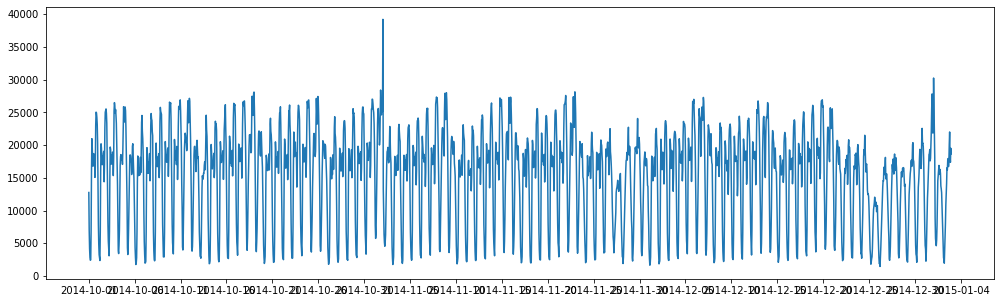

Calculation of  the first discord
The first discord is :  
 [759, 12, 2.746225055671875]
Calculation of the the next four discords
The new added Discord   [758, 13, 2.9819137944892207]
The new added Discord   [757, 14, 3.548134906166143]
The new added Discord   [756, 15, 3.6720512050283083]
The new added Discord   [755, 16, 3.7957113186706652]
Calculation of the the remaining discords
The new added Discord   [754, 17, 3.7305562208642917]
The new added Discord   [753, 18, 3.367888809378271]
The new added Discord   [753, 19, 3.1618392855708963]
The new added Discord   [752, 20, 2.8985780733789492]
The new added Discord   [752, 21, 2.670509417879137]
The new added Discord   [769, 22, 2.513778263195744]
The new added Discord   [769, 23, 2.566742363683388]
The new added Discord   [769, 24, 2.5845448370266633]
The new added Discord   [768, 25, 2.5759320284511205]
The new added Discord   [767, 26, 2.5529234934393505]
The new added Discord   [746, 27, 2.566230465816574]
The new added Discord  

In [ ]:
#Detecting new year event.

# Taking specific parts of the nyc_taxi dataset 

df_taxi = pd.read_csv("/content/nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#selecting a range of dates where we failed to detect some important events.
data =  df_taxi.loc['2014-10-01 00:00:00' : '2015-01-02 23:00:00']

T = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
T = [val for i,val in enumerate(T) if i % 2 == 0]
T = np.asarray(T)

#plottting
plt.figure(figsize=(17,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

start = datetime.datetime.strptime('2014-10-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end = datetime.datetime.strptime('2015-01-03 00:00:00', '%Y-%m-%d %H:%M:%S')


days = mdates.drange(start,end,dt.timedelta(hours=1))

plt.plot(days,T)
plt.show()
np.set_printoptions(suppress=True)
Discords = MERLIN(T, 12, 48)

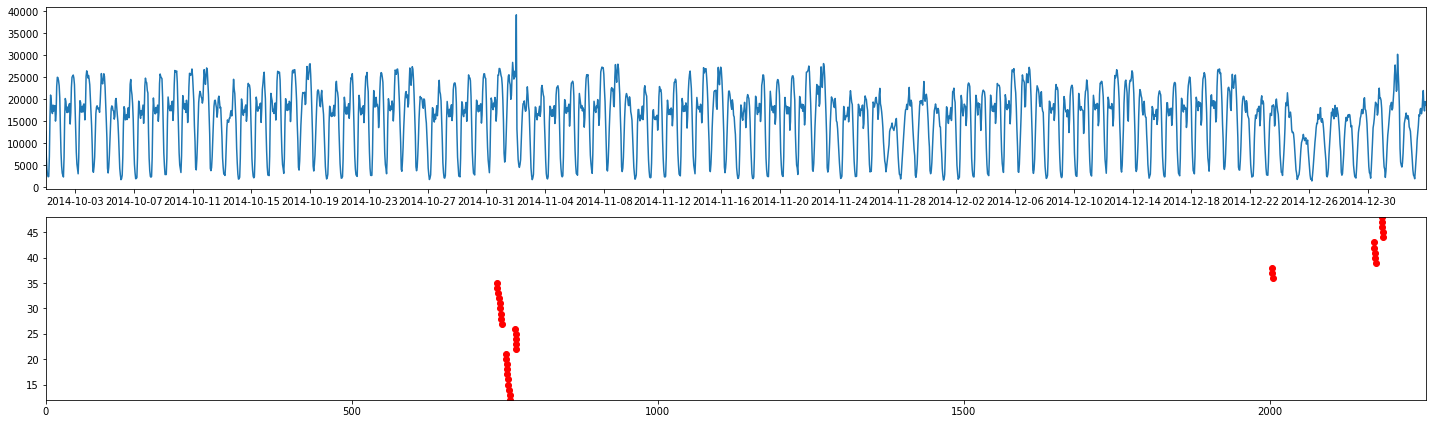

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20,6))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=4))

start = datetime.datetime.strptime('2014-10-01 00:00:00', '%Y-%m-%d %H:%M:%S')

end = datetime.datetime.strptime('2015-01-03 00:00:00', '%Y-%m-%d %H:%M:%S')

days = mdates.drange(start,end,dt.timedelta(hours=1))

ax[0].set_xlim(left=days[0], right=days[-1]) 
ax[0].plot(days,T)

ax[1].set_xlim(left=0, right=len(T)-1) 
ax[1].set_ylim(bottom=12, top=48)

for item in Discords:

    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

We can see that we were able to detect the Daylight Saving day, christmas and the new year event when we took the specific period of time.

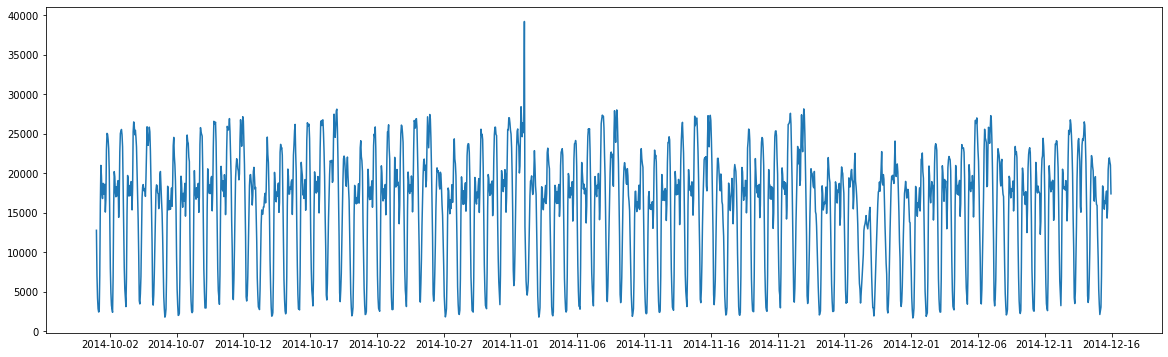

Calculation of  the first discord
The first discord is :  
 [759, 12, 2.746225055671875]
Calculation of the the next four discords
The new added Discord   [758, 13, 2.9819137944892207]
The new added Discord   [757, 14, 3.5977491081910626]
The new added Discord   [756, 15, 3.7262163688495025]
The new added Discord   [755, 16, 3.8542112273477858]
Calculation of the the remaining discords
The new added Discord   [754, 17, 3.773480491623614]
The new added Discord   [753, 18, 3.4080630531206326]
The new added Discord   [753, 19, 3.173663379789231]
The new added Discord   [752, 20, 2.8985780733789492]
The new added Discord   [752, 21, 2.670509417879137]
The new added Discord   [769, 22, 2.513778263195744]
The new added Discord   [769, 23, 2.566742363683388]
The new added Discord   [769, 24, 2.5845448370266633]
The new added Discord   [768, 25, 2.5759320284511205]
The new added Discord   [1352, 26, 2.652018427488421]
The new added Discord   [1352, 27, 2.8994274086369805]
The new added Discord

In [ ]:
# Taking specific parts of the nyc_taxi dataset 
# Detecting the thanksgiving event.


df_taxi = pd.read_csv("/content/nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#selecting a range of dates where we failed to detect some important events.
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']

T = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
T = [val for i,val in enumerate(T) if i % 2 == 0]
T = np.asarray(T)

#plottting
plt.figure(figsize=(20,6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

start = datetime.datetime.strptime('2014-10-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end = datetime.datetime.strptime('2014-12-16 00:00:00', '%Y-%m-%d %H:%M:%S')


days = mdates.drange(start,end,dt.timedelta(hours=1))

plt.plot(days,T)
plt.show()
np.set_printoptions(suppress=True)
Discords = MERLIN(T, 12, 48)



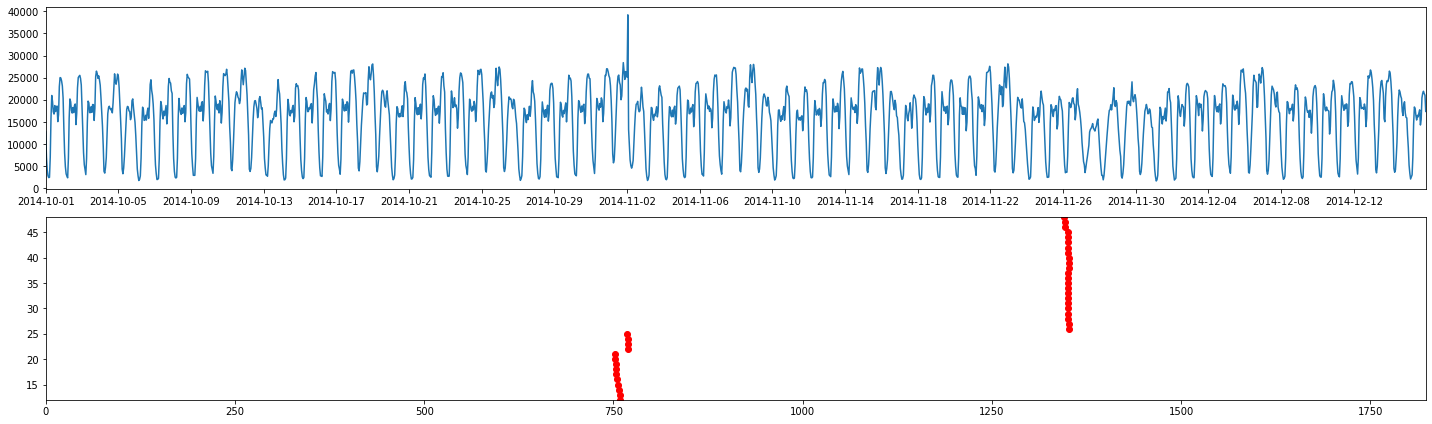

In [ ]:

fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20,6))



ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=4))

start = datetime.datetime.strptime('2014-10-01 00:00:00', '%Y-%m-%d %H:%M:%S')

end = datetime.datetime.strptime('2014-12-16 00:00:00', '%Y-%m-%d %H:%M:%S')

days = mdates.drange(start,end,dt.timedelta(hours=1))

ax[0].set_xlim(left=days[0], right=days[-1]) 
ax[0].plot(days,T)

ax[1].set_xlim(left=0, right=len(T)-1) 
ax[1].set_ylim(bottom=12, top=48)



for item in Discords:


    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

Detecting thanksgiving and the daylight save.However, it's not practical enough. For that reason,  we will consider detecting top K discords instead of only top 1.

We can also adapt MERLIN on DRAG to make it detect the top k discords instead of only top 1.

## Improvement : Calculation of top k discrods

In [ ]:
def DRAG_top_k_discords(T,m,r,number_of_discords=2):
    """
    This function combines the first two algorithms of the merlin.
    
    The method discovers a collection of discords with a distance from their NN greater than r for a time sequence T.
    
    Input
    #######################################################################################################################
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    Output
    #######################################################################################################################
    top_discord_index: nArray
        indexes of top discords
    top_k_NN: nArray
        indexes of NNs of top discords
    top_k_distances: nArray
        distances between top k discord and its NNs  
    """
    
    #initializing output
    index = -1
    distance = -1
    
    C = candidate_selection_algorithm(T, m, r) 
    
    if len(C)==0 :
        print("Failure mode.")
        return -1,-1
    
    if len(C)>0:
        discords = discords_refinement_algorithm(T, m, r, C)
        
        discords_sorted = discords.sort_values(by ='Discord distance', ascending=False, ignore_index=True)
        
        top_k_discrods_dataFrame = discords_sorted[:number_of_discords]
        
        top_discord_index = np.array(top_k_discrods_dataFrame['Discord index'])
        
        top_k_distances = np.array(top_k_discrods_dataFrame['Discord distance'])
        
          
    return top_discord_index, top_k_distances

In [ ]:
def MERLIN_topk(T, min_length, max_length,topk = 2):
    """
    For a time series T, the algorithm finds discords with length between MinL and MaxL. 
    
    Input
    #######################################################################################################################
    T: ndarray
        the time series for which we try to find the discords
    
    min_length: int
        subsequence length lower bound
    
    max_length: int
        subsequence length upper bound
    
    
    Output
    #######################################################################################################################
    Discords : ndarray
        A multi dimensional array of size (max_length-min_length+1) x 3:
          first position contains the starting index of the discord subsequence
          second position contains the length of the discord
          fourth position is the distance of the discord to its NN
    
    """
    Discords = np.empty(shape = (0, 3), dtype='object') 
    
    
    # Calculate the first discord of length min_length
    print('Calculation of  the first discord')
    m = min_length
    r = 2 * (m ** 0.5)
    distance = np.array([-1])
    while any(x<0 for x in distance ) or len(distance)<topk:
        index, distance = DRAG_top_k_discords(T, m, r, number_of_discords=topk)
        r = r / 2
    new_discord = [index, m, distance]
    discord = np.vstack((Discords, new_discord))
    print('The first discord is :  \n', discord)
    
    print('Calculation of the the next four discords')
    
    old_distance = distance[0] # we need the dist of the previous discord to modify r
    for m in range(min_length+1,min_length+5): 
        r = 0.99 * old_distance 
        
        distance = np.array([-1])
        while any(x<0 for x in distance ) or len(distance)<topk :
            index, distance = DRAG_top_k_discords(T, m, r,number_of_discords=topk)
            r = 0.99 * r
            
        discord = [index, m, distance]
        Discords = np.vstack((Discords, discord))
        old_distance = distance[0]
        print('The new added Discord  ', discord)
    
    # Calculate the remaining discords
    print('Calculation of the the remaining discords')
    for m in range(min_length+5, max_length+1): 
        mu_distance = np.mean(Discords[-5:, 2][0]) # calculating the mean of distance of the last 5 discovered discords 
        std_distance = np.std(Discords[-5:, 2][0]) # calculating the std of distance of the last 5 discovered discords
        r = mu_distance - 2 * std_distance
        distance = np.array([-1])
        while any(x<0 for x in distance ) or len(distance)<topk :
            index ,distance = DRAG_top_k_discords(T, m, r,number_of_discords=topk)
            r = r - std_distance
        
        discord = [index, m, distance]
        Discords = np.vstack((Discords, discord))
        print('The new added Discord  ', discord)
    
    return Discords

In [ ]:
df_taxi = pd.read_csv("/content/nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-07-01 00:00:00' : '2015-01-31 23:30:00']

T = np.reshape(data.to_numpy(),newshape=(-1,))

#let's consider only the data at each hour (to reduce computational time)

T = [val for i,val in enumerate(T) if i % 2 == 0]
T = np.asarray(T)

top_4_Discords = MERLIN_topk(T, 5, 48,topk = 4 )

np.savetxt("NYC_taxi_top4_5-48.csv", T, delimiter=",")

Calculation of  the first discord
The first discord is :  
 [[array([3947., 3898., 4652., 3442.]) 5
  array([0.91602184, 0.86207834, 0.84092003, 0.8113543 ])]]
Calculation of the the next four discords
The new added Discord   [array([4812.,  304., 4651., 2026.]), 6, array([1.55474111, 1.34949017, 1.27130237, 1.22071047])]
The new added Discord   [array([1477., 4502.,   88., 1478.]), 7, array([1.87967831, 1.85386815, 1.82651834, 1.8124005 ])]
The new added Discord   [array([1477., 4501.,   87.,  113.]), 8, array([2.54550296, 1.94617087, 1.93748927, 1.66282104])]
The new added Discord   [array([4500.,   87., 2970., 1477.]), 9, array([2.44569927, 2.06544506, 2.06348589, 1.96749543])]
Calculation of the the remaining discords
The new added Discord   [array([4261., 2969., 3590.,   87.]), 10, array([2.35220917, 2.12475379, 2.05346911, 2.0423159 ])]
The new added Discord   [array([  87., 4260., 2968.,   85.]), 11, array([2.49701343, 2.47367769, 2.39325298, 2.29163789])]
The new added Discord 

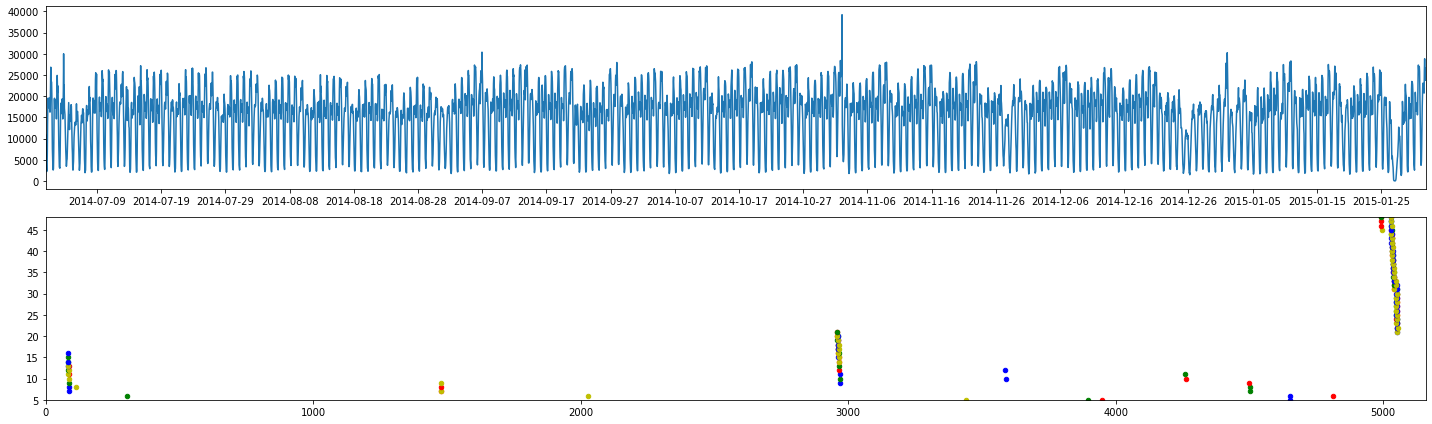

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20,6))

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=10))

start = datetime.datetime.strptime('2014-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end = datetime.datetime.strptime('2015-01-31 23:30:00', '%Y-%m-%d %H:%M:%S')
days = mdates.drange(start,end,dt.timedelta(hours=1))

ax[0].set_xlim(left=days[0], right=days[-1]) 
ax[0].plot(days,T)

ax[1].set_xlim(left=0, right=len(T)-1) 
ax[1].set_ylim(bottom=5, top=48)

colors = ['r','g','b','y']
for item in top_4_Discords :
    for idx in range(len(item[0])) :
      ax[1].scatter(x=int(item[0][idx]), y=int(item[1]),c=colors[idx],s=20)

fig.tight_layout()
plt.show()

### Comparision with Matrix Profile.

Let's try to see if the discords found by merlin algorithm corresponds also to the one found by the matrix profil.

In [ ]:
import matrixprofile as mp
from matplotlib import pyplot as plt
from matrixprofile.visualize import plot_discords_mp
%matplotlib inline

In [ ]:
dataset = mp.datasets.load('nyc-taxi-anomalies.csv')

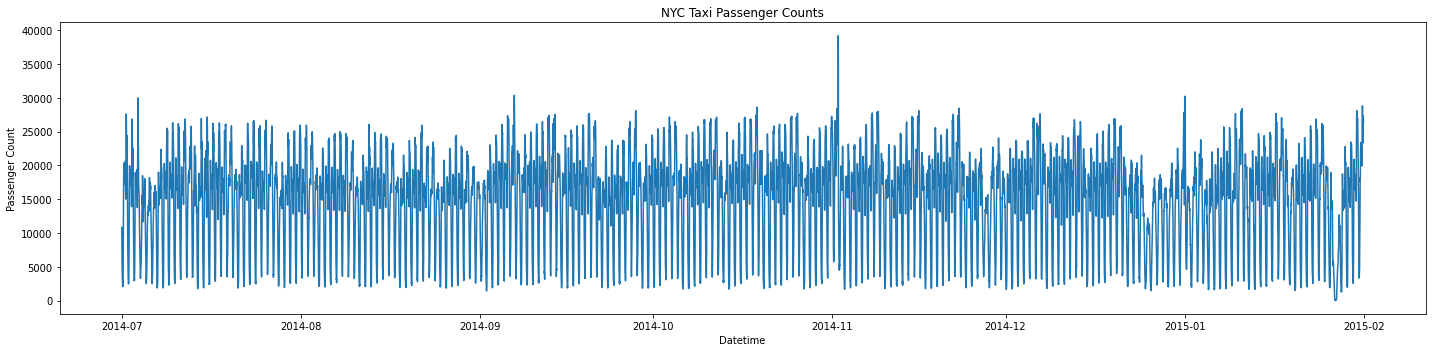

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dataset['datetime'], dataset['data'])
plt.title('NYC Taxi Passenger Counts')
plt.ylabel('Passenger Count')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

C:\Users\saife\anaconda3\lib\site-packages\matrixprofile\visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


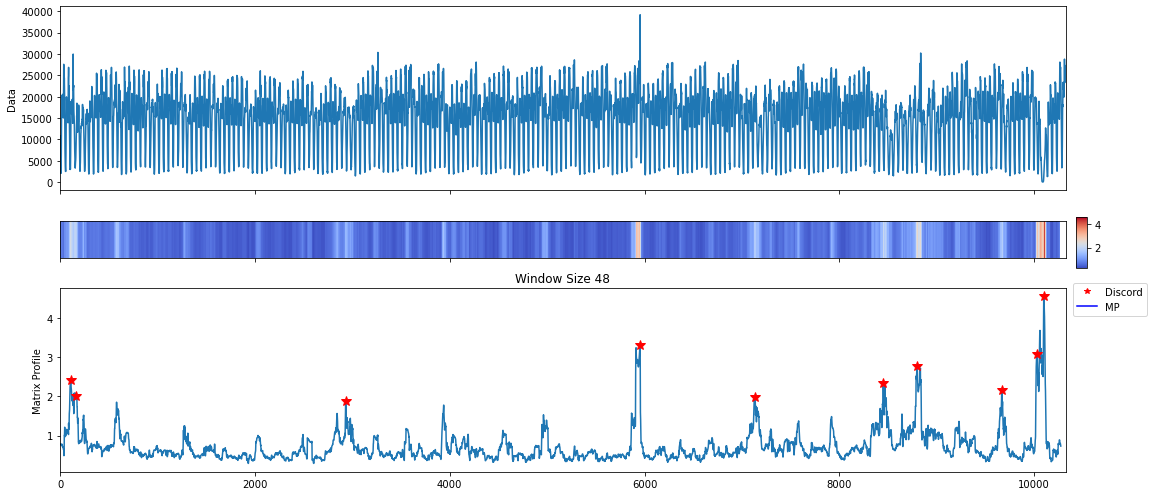

In [ ]:
window_size = 48
profile = mp.compute(dataset['data'], windows=window_size)
profile = mp.discover.discords(profile, exclusion_zone=window_size, k=10)

plot_discords_mp(profile)
plt.show()

In [ ]:
for dt in dataset['datetime'][profile['discords']]:
    print(dt)

2015-01-27T09:00:00
2014-11-02T00:30:00
2015-01-25T20:30:00
2014-12-31T05:30:00
2014-07-03T07:00:00
2014-12-24T00:30:00
2015-01-18T09:00:00
2014-07-04T07:00:00
2014-11-26T15:00:00
2014-08-31T01:30:00


## Yahoo dataset TS100

In [ ]:
#read data
df_yahoo = pd.read_csv("A4Benchmark-TS100.csv") 
timestamps =df_yahoo['timestamps']
df_yahoo = df_yahoo.set_index(['timestamps'])
df_yahoo.head()

,value,anomaly,changepoint,trend,noise,seasonality1,seasonality2,seasonality3
timestamps,,,,,,,,
1.416722e+09,-10.258903,0,0,0,-10.258903,0.000000,0.000000,0.000000
1.416726e+09,141.132619,0,0,0,-5.156569,94.200000,46.121554,5.967635
1.416730e+09,260.483286,0,0,0,-3.702823,163.159186,89.100000,11.926923
1.416733e+09,319.502977,0,0,0,-12.772982,188.400000,126.006428,17.869530
1.416737e+09,346.294528,0,0,0,5.022469,163.159186,154.325727,23.787146


(1416722400.0, 1422766800.0)

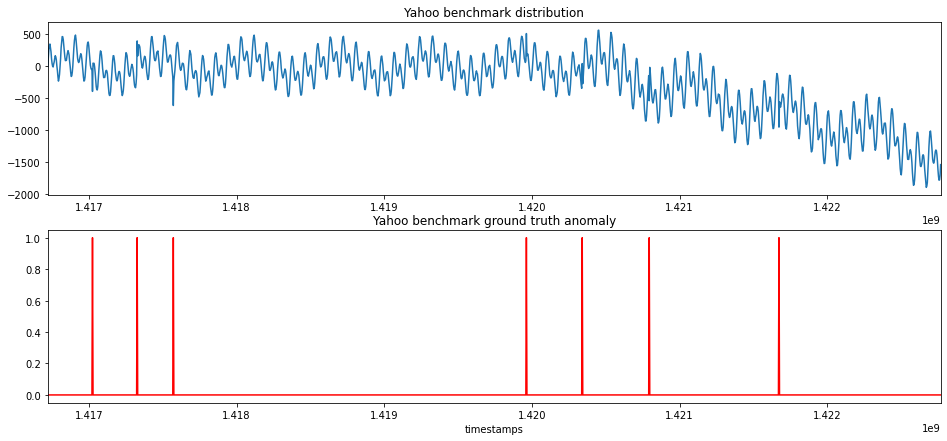

In [ ]:
data = df_yahoo['value']
real_anomaly = df_yahoo['anomaly']

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(16,7))

data.plot(ax=axes[0])
axes[0].set_title('Yahoo benchmark distribution')
axes[0].set_xlabel('')
real_anomaly.plot(ax=axes[1],color=['red'])
axes[1].set_title('Yahoo benchmark ground truth anomaly')
axes[0].set_xlim(left=timestamps[0], right=timestamps[len(timestamps)-1]) 

axes[1].set_xlim(left=timestamps[0], right=timestamps[len(timestamps)-1]) 

In [ ]:
T = np.reshape(data.to_numpy(),newshape=(-1,))
T = np.asarray(T)
Discords = MERLIN(T, 5, 100)

Calculation of  the first discord
The first discord is :  
 [1128, 5, 1.6281223737449875]
Calculation of the the next four discords
The new added Discord   [1127, 6, 1.8815867512348252]
The new added Discord   [898, 7, 2.182730678227327]
The new added Discord   [897, 8, 2.424683658270419]
The new added Discord   [896, 9, 2.597439635765145]
Calculation of the the remaining discords
The new added Discord   [895, 10, 2.711542249607856]
The new added Discord   [895, 11, 2.710298249376845]
The new added Discord   [1374, 12, 2.987712120392044]
The new added Discord   [1374, 13, 3.0527814564316]
The new added Discord   [992, 14, 2.884622483386493]
The new added Discord   [992, 15, 3.030033272786981]
The new added Discord   [992, 16, 3.117986719796063]
The new added Discord   [991, 17, 3.183308432037545]
The new added Discord   [991, 18, 3.1800990661371826]
The new added Discord   [990, 19, 3.030996396366052]
The new added Discord   [990, 20, 2.773089028736774]
The new added Discord   [989, 21

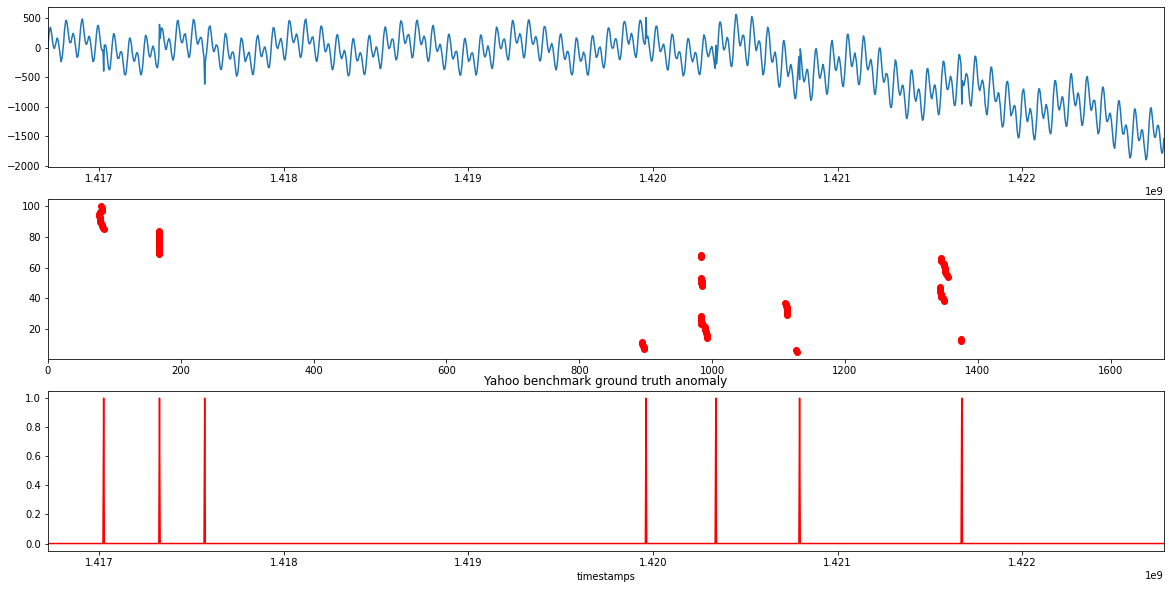

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20,10))

data.plot(ax=ax[0])
ax[0].set_xlim(left=timestamps[0], right=timestamps[len(timestamps)-1]) 
ax[0].set_xlabel('')

for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

ax[1].set_xlim(left=0, right=len(data)) 
real_anomaly.plot(ax=ax[2],color=['red'])

ax[2].set_title('Yahoo benchmark ground truth anomaly')
ax[2].set_xlim(left=timestamps[0], right=timestamps[len(timestamps)-1]) 

ax[1].set_xlabel('')

plt.show()

In [ ]:
start = time.time()
data = df_yahoo['value']
real_anomaly = df_yahoo['anomaly']
T = np.reshape(data.to_numpy(),newshape=(-1,))
T = np.asarray(T)

end = time.time()
top_2Discords = MERLIN_topk(T, 5, 100,topk = 7 )
end = time.time()

print('running_time',end-start)

Calculation of  the first discord
The first discord is :  
 [[array([1128.,  899.,   81., 1373.,  234., 1130., 1004.]) 5
  array([1.62812237, 1.5058341 , 1.22981271, 1.05804683, 1.02730066,
         0.96607171, 0.94820693])                                   ]]
Calculation of the the next four discords
The new added Discord   [array([1127., 1128.,  899., 1130.,  898., 1004.,   81.]), 6, array([1.88158675, 1.66750034, 1.63035956, 1.52628289, 1.52605968,
       1.49504645, 1.4205118 ])]
The new added Discord   [array([ 898., 1128., 1127.,  168., 1374.,   83., 1130.]), 7, array([2.18273068, 1.89571718, 1.85182066, 1.8486303 , 1.8486303 ,
       1.82195099, 1.82195099])]
The new added Discord   [array([ 897., 1374., 1128.,  898., 1127.,  896., 1001.]), 8, array([2.42468366, 2.42157987, 2.2044465 , 2.1730027 , 2.03396303,
       2.00815832, 2.00815832])]
The new added Discord   [array([ 896., 1374.,  897.,   81., 1128., 1127.,  167.]), 9, array([2.59743964, 2.4436277 , 2.40350938, 2.37665642

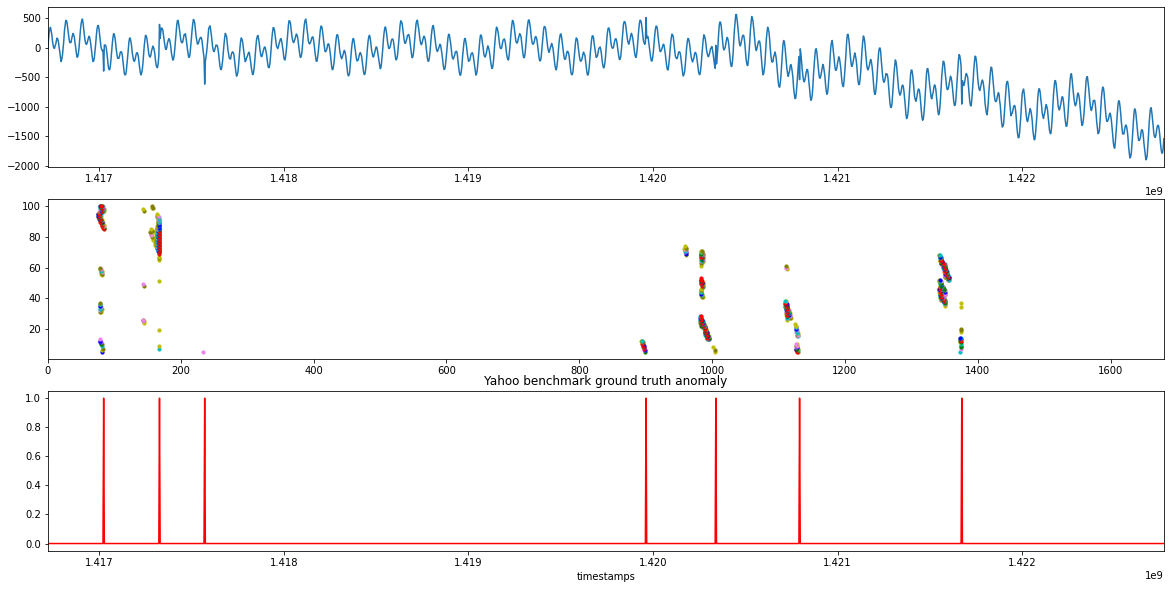

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20,10))

data.plot(ax=ax[0])
ax[0].set_xlim(left=timestamps[0], right=timestamps[len(timestamps)-1]) 
ax[0].set_xlabel('')
colors = ['r','g','b','c','violet','olive','y']
for item in top_2Discords :

    for idx in range(len(item[0])-1,-1,-1) :
      ax[1].scatter(x=int(item[0][idx]), y=int(item[1]),c=colors[idx],s=10)

ax[1].set_xlim(left=0, right=len(data)) 
real_anomaly.plot(ax=ax[2],color=['red'])

ax[2].set_title('Yahoo benchmark ground truth anomaly')
ax[2].set_xlim(left=timestamps[0], right=timestamps[len(timestamps)-1]) 
ax[1].set_xlabel('')

plt.show()

## Mars Science Laboratory (MSL) rover dataset

In [ ]:
T = pd.read_csv('/content/A-4.txt', header=None) 

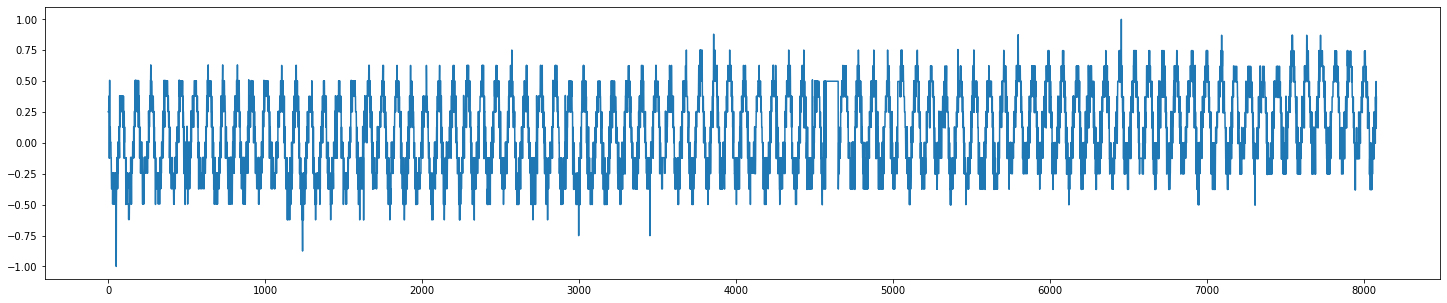

In [ ]:
T = np.reshape(T.to_numpy(), newshape = (-1,))
plt.figure(figsize=(25,5))
plt.plot(T)


In [ ]:
Discords = MERLIN(T, 100, 200)

Calculation of  the first discord
The first discord is :  
 [4621, 100, 10.157667158169057]
Calculation of the the next four discords
The new added Discord   [4620, 101, 10.171757142764069]
The new added Discord   [4619, 102, 10.193530884863417]
The new added Discord   [4618, 103, 10.208695545907492]
The new added Discord   [4617, 104, 10.224365047213018]
Calculation of the the remaining discords
The new added Discord   [4616, 105, 10.2424915316635]
The new added Discord   [4615, 106, 10.260912384895944]
The new added Discord   [4614, 107, 10.285186138845479]
The new added Discord   [4613, 108, 10.302649592211662]
The new added Discord   [4612, 109, 10.322338743407988]
The new added Discord   [4611, 110, 10.340578110204584]
The new added Discord   [4610, 111, 10.35914295072343]
The new added Discord   [4609, 112, 10.378014689407877]
The new added Discord   [4608, 113, 10.399021554056864]
The new added Discord   [4607, 114, 10.420186984073252]
The new added Discord   [4606, 115, 10.4399

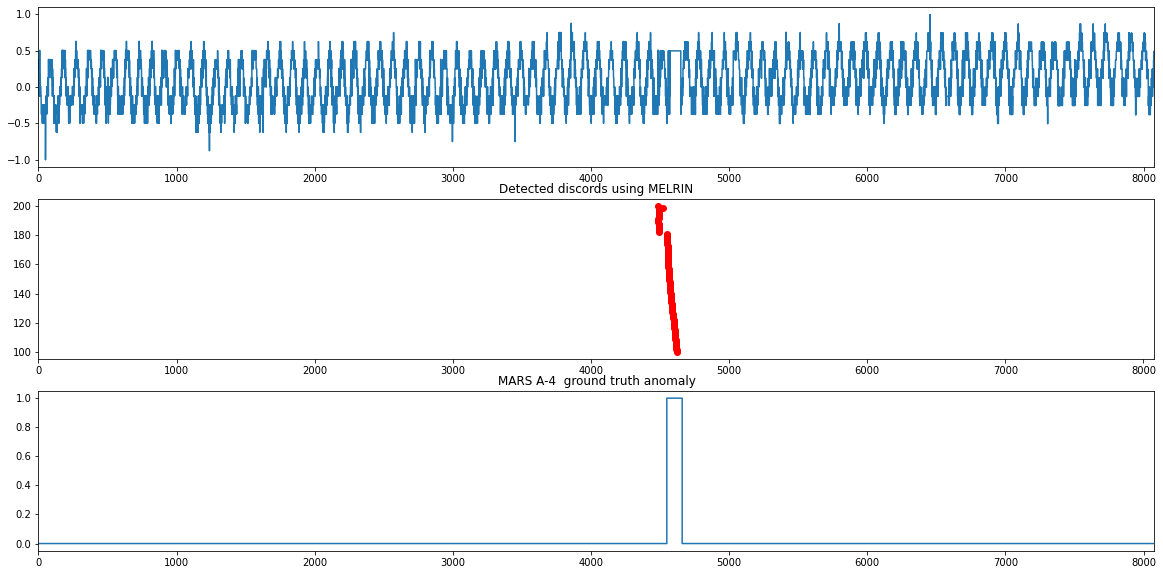

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(20,10))

ax[0].plot(T)
ax[0].set_xlim(left=0, right=len(T)-1) 
ax[0].set_xlabel('')

for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')
ax[1].set_title('Detected discords using MELRIN')
ax[1].set_xlim(left=0, right=len(T)) 

anomalies = pd.read_csv('/content/A-4.txt', header=None) 
anomalies = anomalies.to_numpy()
anomalies_array = np.zeros((len(T)))
anomalies_array[anomalies[0][0]:anomalies[0][1]+1] = 1 
ax[2].step(np.arange(0, len(T)), anomalies_array)



ax[2].set_title('MARS A-4  ground truth anomaly')
ax[2].set_xlim(left=0, right=len(T)-1) 
ax[1].set_xlabel('')

plt.show()

ECG heartbeat

In [ ]:
T = pd.read_csv('/content/ecg-heartbeat-av.txt', header=None) 
T = np.reshape(T.to_numpy(), newshape = (-1, ))

downsampling because i takes too much time to run

In [ ]:
T = [val for i,val in enumerate(T) if i % 2 == 0]

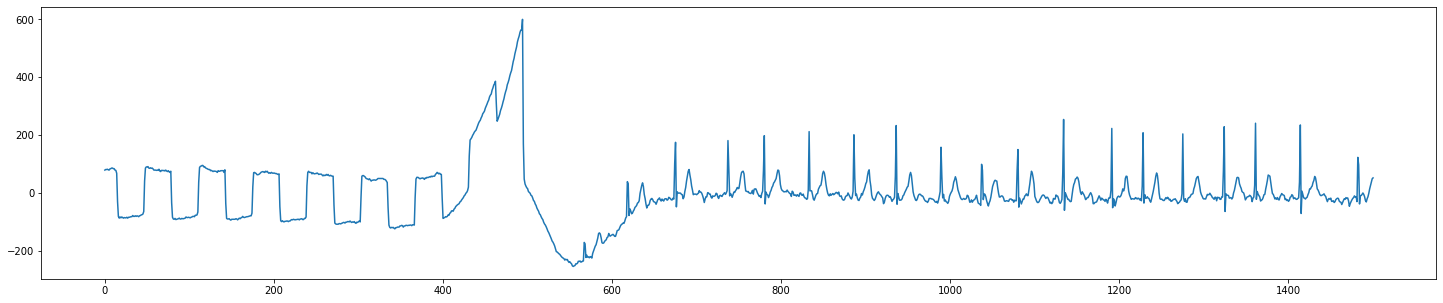

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(T)

In [ ]:
Discords = MERLIN(T, 5, 250)

Calculation of  the first discord
The first discord is :  
 [23, 5, 1.023994176988858]
Calculation of the the next four discords
The new added Discord   [323, 6, 2.4494897427831774]
The new added Discord   [323, 7, 2.6457513110645894]
The new added Discord   [83, 8, 1.86570986234283]
The new added Discord   [257, 9, 2.2367957003348264]
Calculation of the the remaining discords
The new added Discord   [1213, 10, 2.3123557359832136]
The new added Discord   [17, 11, 2.514451389904469]
The new added Discord   [1213, 12, 2.829646919895658]
The new added Discord   [1213, 13, 3.0410777958989845]
The new added Discord   [654, 14, 3.2929756240487427]
The new added Discord   [659, 15, 3.215854511270304]
The new added Discord   [655, 16, 3.5194067947840066]
The new added Discord   [655, 17, 3.6417291540727454]
The new added Discord   [125, 18, 3.8448094908087787]
The new added Discord   [655, 19, 3.937974016962561]
The new added Discord   [654, 20, 4.029513014097888]
The new added Discord   [653,

(0.0, 1501.0)

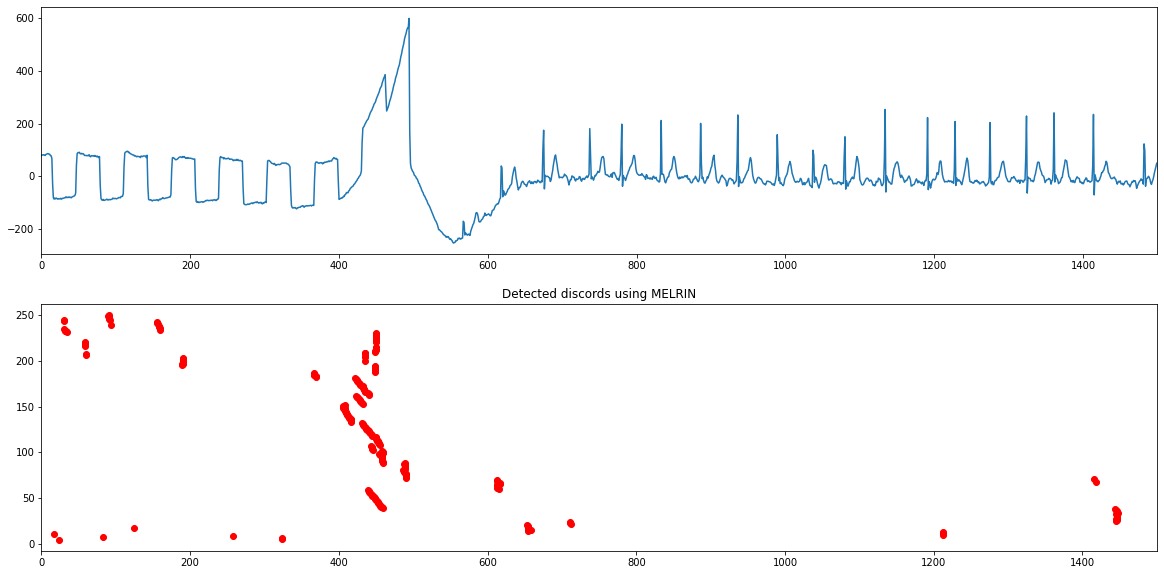

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20,10))

ax[0].plot(T)
ax[0].set_xlim(left=0, right=len(T)-1) 
ax[0].set_xlabel('')

for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')
ax[1].set_title('Detected discords using MELRIN')
ax[1].set_xlim(left=0, right=len(T)) 

We can't say much about this dataset since we don't really have the ground truth of the detected anomalies but visually, we are pretty sure that the MERLIN algorithm detected the big anomalies presented between 400-600 inthe timestamps index.